In [23]:
# ============================================
# Cell 1 - Imports and basic configuration
# ============================================

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

# Use a nice style for plots
sns.set(style="whitegrid", context="notebook")

# Create plots directory if it does not exist
os.makedirs("plots", exist_ok=True)


In [26]:
# ============================================
# Cell 2 - Load dataset and initial overview
# ============================================

# Define column names according to the UCI Cleveland dataset description
column_names = [
    "age", "sex", "cp", "trestbps", "chol",
    "fbs", "restecg", "thalach", "exang",
    "oldpeak", "slope", "ca", "thal", "target"
]

# Load raw heart.csv (no header inside file)
df = pd.read_csv("heart.csv", header=None, names=column_names)

print("Shape:", df.shape)

print("\nFirst 5 rows:")
display(df.head())

print("\nDataFrame info:")
print(df.info())


Shape: (303, 14)

First 5 rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB
None


In [27]:
# ============================================
# Cell 3 - Cleaning + binary target + sanity checks
# ============================================

# Replace '?' with NaN so pandas recognizes missing values
df = df.replace("?", np.nan)

# Convert all columns to numeric values (coerce invalid values to NaN)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print("Missing values per column:")
print(df.isna().sum())

# Drop rows with missing values (Cleveland dataset only loses a few rows)
df = df.dropna().reset_index(drop=True)

print("\nShape after dropping missing values:", df.shape)

# Convert original target (0–4) to binary:
# 0 = no disease, 1–4 = disease
df["target"] = (df["target"] > 0).astype(int)

print("\nTarget value counts AFTER binarization:")
print(df["target"].value_counts())

print("\nUnique classes in target:", df["target"].unique())


Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

Shape after dropping missing values: (297, 14)

Target value counts AFTER binarization:
target
0    160
1    137
Name: count, dtype: int64

Unique classes in target: [0 1]


Statistical summary:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,0.499340
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


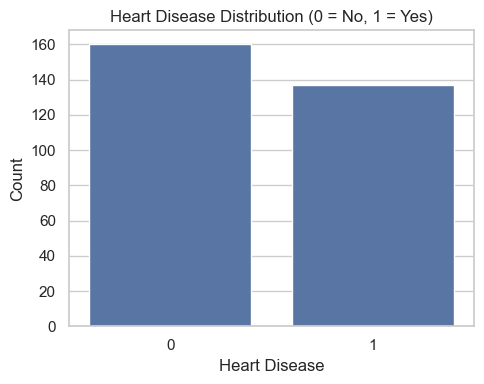

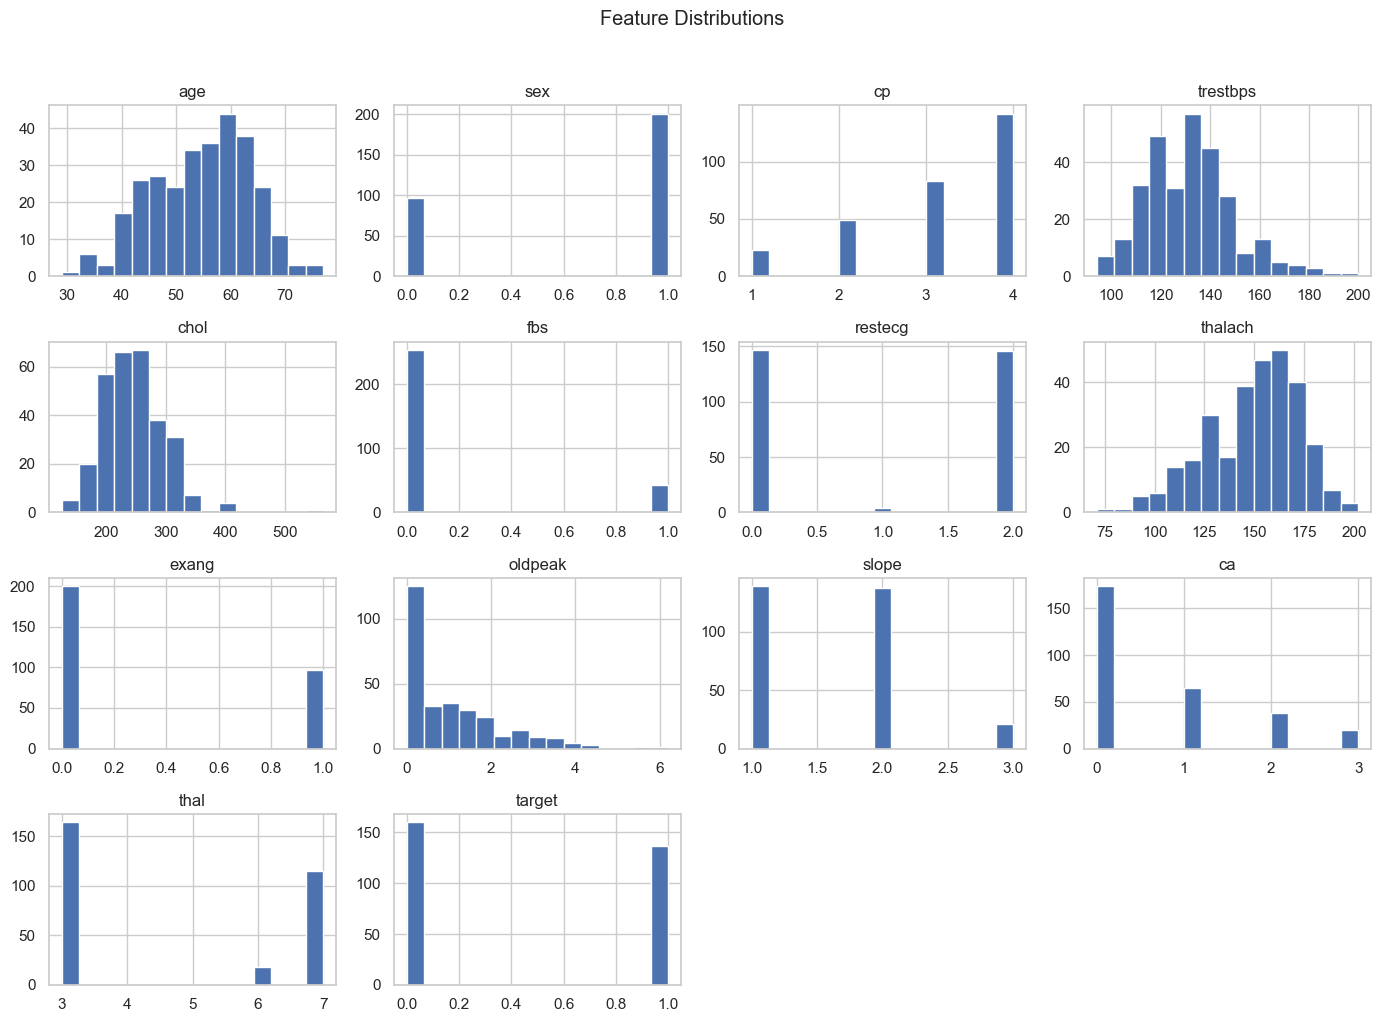

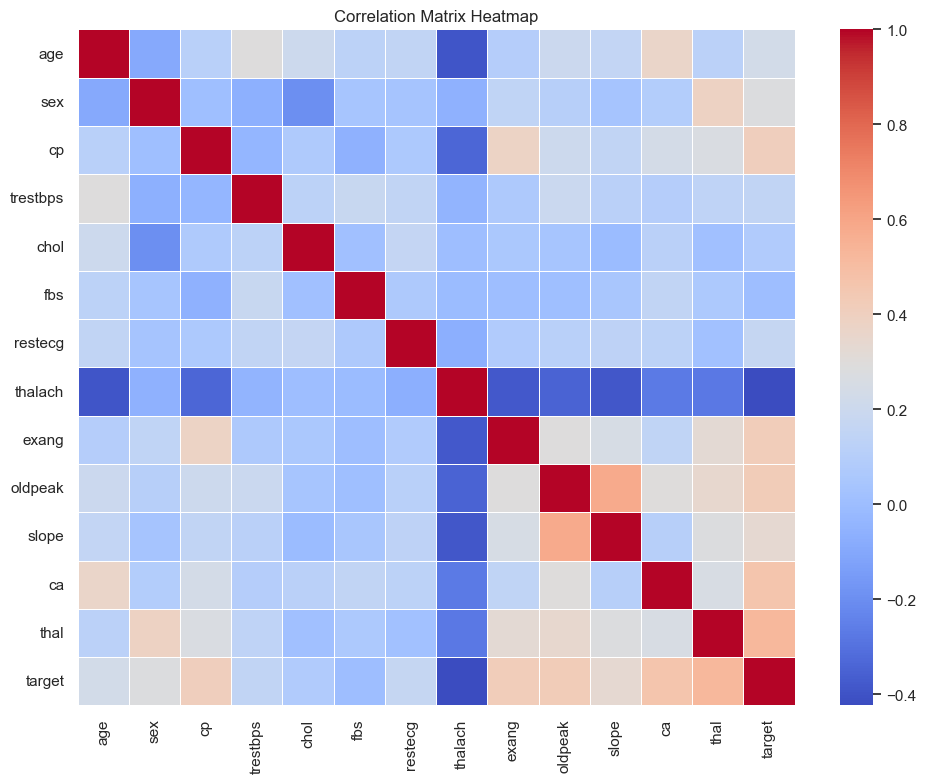

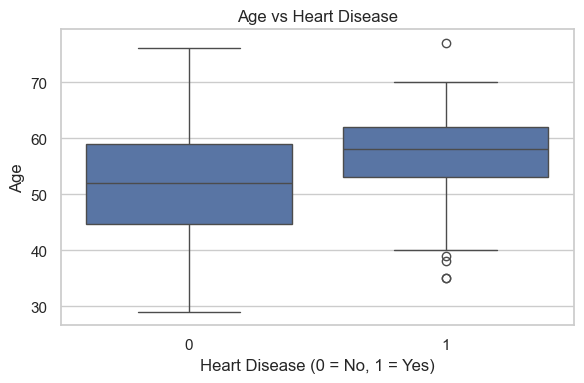

In [28]:
# ============================================
# Cell 4 - Exploratory Data Analysis (EDA)
# ============================================

# Basic statistical summary
print("Statistical summary:")
display(df.describe())

# 4.1 Target distribution
plt.figure(figsize=(5, 4))
sns.countplot(x="target", data=df)
plt.title("Heart Disease Distribution (0 = No, 1 = Yes)")
plt.xlabel("Heart Disease")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("plots/target_distribution.png", bbox_inches="tight")
plt.show()

# 4.2 Histograms of all numerical features
df.hist(figsize=(14, 10), bins=15)
plt.suptitle("Feature Distributions", y=1.02)
plt.tight_layout()
plt.savefig("plots/feature_histograms.png", bbox_inches="tight")
plt.show()

# 4.3 Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.savefig("plots/correlation_heatmap.png", bbox_inches="tight")
plt.show()

# 4.4 Boxplot age vs target
plt.figure(figsize=(6, 4))
sns.boxplot(x="target", y="age", data=df)
plt.title("Age vs Heart Disease")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.tight_layout()
plt.savefig("plots/boxplot_age_target.png", bbox_inches="tight")
plt.show()


In [29]:
# ============================================
# Cell 5 - Train-test split and scaling
# ============================================

# Separate features and target
X = df.drop("target", axis=1)
Y = df["target"]

print("Overall target distribution:")
print(Y.value_counts(), "\n")

# Stratified split to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

print("\nTarget distribution in TRAIN:")
print(y_train.value_counts())

print("\nTarget distribution in TEST:")
print(y_test.value_counts())

# Safety checks
if len(y_train.unique()) < 2:
    raise ValueError("ERROR: y_train contains only one class.")
if len(y_test.unique()) < 2:
    raise ValueError("ERROR: y_test contains only one class.")

# Standardization (only for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Overall target distribution:
target
0    160
1    137
Name: count, dtype: int64 

Training set shape: (237, 13)
Test set shape: (60, 13)

Target distribution in TRAIN:
target
0    128
1    109
Name: count, dtype: int64

Target distribution in TEST:
target
0    32
1    28
Name: count, dtype: int64


Unique classes in y_train: [1 0]
Logistic Regression - Accuracy: 0.8333

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.85      0.79      0.81        28

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60



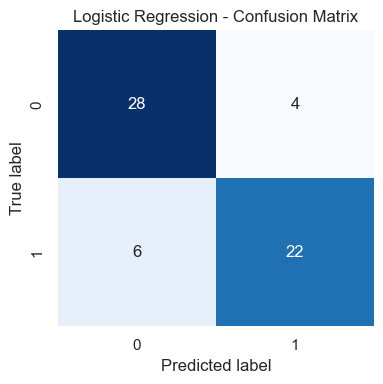

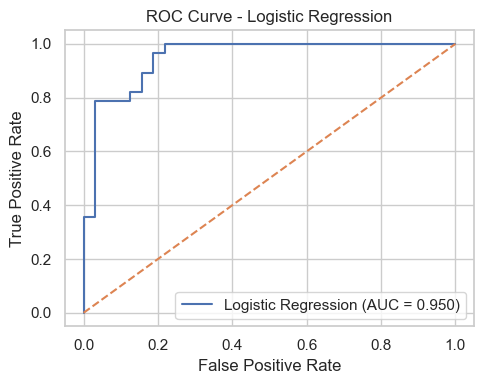

In [30]:
# ============================================
# Cell 6 - Logistic Regression: training and evaluation
# ============================================

print("Unique classes in y_train:", y_train.unique())

# Initialize Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Fit model
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_log = log_reg.predict(X_test_scaled)
y_proba_log = log_reg.predict_proba(X_test_scaled)[:, 1]

# Accuracy
accuracy_log = accuracy_score(y_test, y_pred_log)
print(f"Logistic Regression - Accuracy: {accuracy_log:.4f}\n")

# Classification report
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_log))

# Confusion Matrix
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("plots/logistic_confusion_matrix.png", bbox_inches="tight")
plt.show()

# ROC Curve
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_proba_log)
auc_log = roc_auc_score(y_test, y_proba_log)

plt.figure(figsize=(5, 4))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("plots/logistic_roc_curve.png", bbox_inches="tight")
plt.show()


Random Forest - Accuracy: 0.8667

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.88      0.82      0.85        28

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.87        60
weighted avg       0.87      0.87      0.87        60



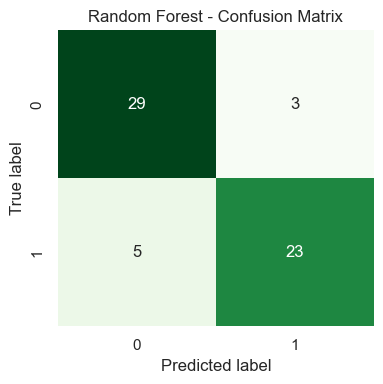

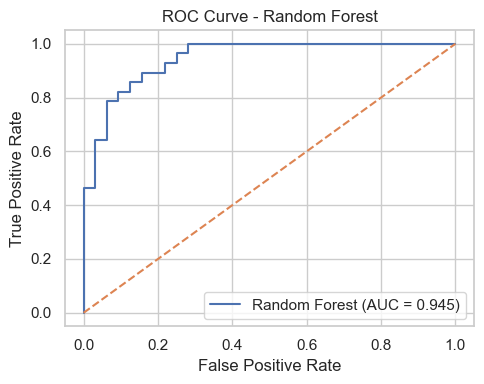

In [31]:
# ============================================
# Cell 7 - Random Forest: training and evaluation
# ============================================

# Initialize Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest - Accuracy: {accuracy_rf:.4f}\n")

# Classification report
print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("plots/random_forest_confusion_matrix.png", bbox_inches="tight")
plt.show()

# ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(5, 4))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("plots/random_forest_roc_curve.png", bbox_inches="tight")
plt.show()


In [32]:
# ============================================
# Cell 8 - Model comparison
# ============================================

print("Model comparison (Accuracy and AUC):\n")
print(f"Logistic Regression - Accuracy: {accuracy_log:.4f}, AUC: {auc_log:.4f}")
print(f"Random Forest       - Accuracy: {accuracy_rf:.4f}, AUC: {auc_rf:.4f}")


Model comparison (Accuracy and AUC):

Logistic Regression - Accuracy: 0.8333, AUC: 0.9498
Random Forest       - Accuracy: 0.8667, AUC: 0.9453
